## Example Scripts to Get Started

In [73]:
from numba import njit
from hftbacktest import GTX, LIMIT, Recorder
from hftbacktest.stats import LinearAssetRecord
import numpy as np

# numba.njit is strongly recommended for fast backtesting.
@njit
def print_bbo(hbt):
    # Iterating until hftbacktest reaches the end of data.
    # Elapses 60-sec every iteration.
    # Time unit is the same as data's timestamp's unit.
    # Timestamp of the sample data is in nanoseconds.
    while hbt.elapse(60 * 1e9) == 0:
        # Gets the market depth for the first asset.
        depth = hbt.depth(0)

        # Prints the best bid and the best offer.
        print(
            'current_timestamp:', hbt.current_timestamp,
            ', best_bid:', np.round(depth.best_bid, 5),
            ', best_ask:', np.round(depth.best_ask, 5)
        )
    return True



In [74]:
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest

asset = (
    BacktestAsset()
        .data(['hft_db/beerusdt_20240601.npz'])
        # .initial_snapshot('usdm/btcusdt_20240808_eod.npz') # Not needed with Tardis
        # Asset type:
        # * Linear
        # * Inverse.
        # 1.0 represents the contract size, which is the value of the asset per quoted price.
        .linear_asset(1.0)
        # HftBacktest provides two built-in latency models.
        # * constant_latency
        # * intp_order_latency
        # Time unit is the same as data's timestamp's unit. Timestamp of the sample data is in nanoseconds.
        # Sets the order entry latency and response latency to 10ms.
        .constant_latency(10_000_000, 10_000_000)
        # HftBacktest provides several types of built-in queue position models.
        .risk_adverse_queue_model()
        # HftBacktest provides two built-in exchange models.
        # * no_partial_fill_exchange
        # * partial_fill_exchange
        .no_partial_fill_exchange()
        # HftBacktest provides several built-in fee models.
        # * trading_value_fee_model
        # * trading_qty_fee_model
        # * flat_per_trade_fee_model
        #
        # 0.02% maker fee and 0.07% taker fee. If the fee is negative, it represents a rebate.
        # For example, -0.00005 represents a 0.005% rebate for the maker order.
        .trading_value_fee_model(-0.00005, 0.00005)
        # Tick size of this asset: minimum price increasement
        .tick_size(0.00001)
        # Lot size of this asset: minimum trading unit.
        .lot_size(0.1)
        # Sets the capacity of the vector that stores trades occurring in the market.
        # If you set the size, you need call `clear_last_trades` to clear the vector.
        # A value of 0 indicates that no market trades are stored. (Default)
        .last_trades_capacity(0)
)

# HftBacktest provides several types of built-in market depth implementations.
# HashMapMarketDepthBacktest constructs a Backtest using a HashMap-based market depth implementation.
# Another useful implementation is ROIVectorMarketDepth, which is utilized in ROIVectorMarketDepthBacktest.
# Please find the details in the document below.
# hbt = HashMapMarketDepthBacktest([asset])

In [75]:
@njit
def submit_order_stats(hbt, recorder):
    buy_order_id = 1
    sell_order_id = 2
    half_spread = 5 * hbt.depth(0).tick_size


    while hbt.elapse(1 * 1e9) == 0:
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        mid_price = (depth.best_bid + depth.best_ask) / 2.0

        if buy_order_id not in hbt.orders(0):
            order_price = round((mid_price - half_spread) / depth.tick_size) * depth.tick_size
            order_qty = 0.1
            time_in_force = GTX
            order_type = LIMIT
            hbt.submit_buy_order(0, buy_order_id, order_price, order_qty, time_in_force, order_type, False)
        else:
            hbt.cancel(0, buy_order_id, False)

        if sell_order_id not in hbt.orders(0):
            order_price = round((mid_price + half_spread) / depth.tick_size) * depth.tick_size
            order_qty = 0.1
            time_in_force = GTX
            order_type = LIMIT
            hbt.submit_sell_order(0, sell_order_id, order_price, order_qty, time_in_force, order_type, False)
        else:
            hbt.cancel(0, sell_order_id, False)

        recorder.record(hbt)
    return True

hbt = HashMapMarketDepthBacktest([asset])

recorder = Recorder(
    # The number of assets
    hbt.num_assets,
    # The buffer size for records
    1000000
)

submit_order_stats(hbt, recorder.recorder)

_ = hbt.close()
# recorder.get(0)

In [76]:
# recorder.get(0)

record = LinearAssetRecord(recorder.get(0))
stats = record.stats()
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-05-31 23:59:50,2024-06-01 23:59:50,NaN,NaN,NaN,0.685918,19838.0,346.152731,NaN,NaN,6.156058


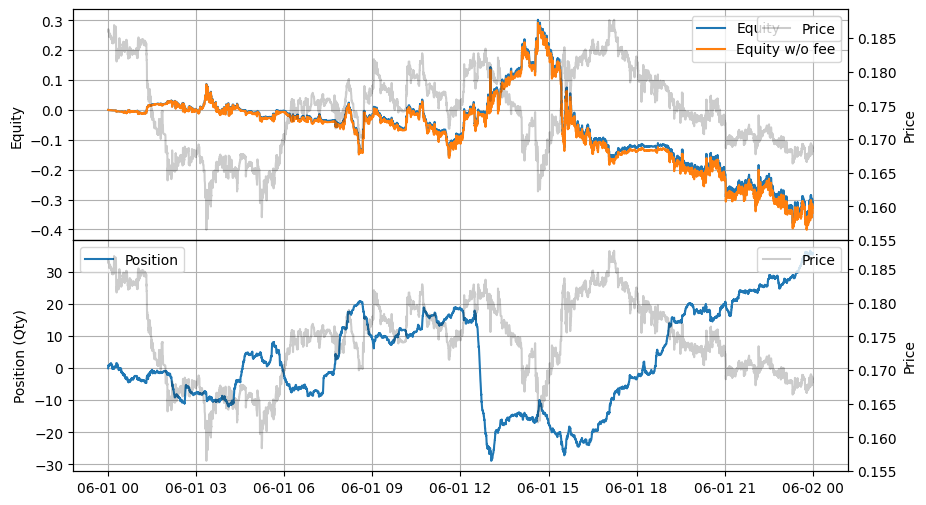

In [77]:

stats.plot()